In [ ]:
%pip install --upgrade pip #upgrade pip package installer
%pip install scikit-learn --upgrade #upgrade scikit-learn package
%pip install numpy --upgrade #upgrade numpy package
%pip install --upgrade matplotlib # Κάνουμε update την matplotlib

In [21]:
import pandas as pd
import numpy as np

df = pd.read_csv('../FeatureEngineering/MetaData/data6_&_odds.csv')
df.dropna(inplace=True)

## KNN with GridSearchCV

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')

In [23]:
train_data = df.loc[(df.season <= 2013) & (df.season >= 2007)]
valid_data = df.loc[(df.season > 2013) & (df.season < 2016)]
test_data = df.loc[df.season >= 2016]
full_train_data = pd.concat([train_data, valid_data], axis=0)

X, y = train_data.drop(columns=['home_team_wins']), train_data.home_team_wins
valid_X, valid_y = valid_data.drop(columns=['home_team_wins']), valid_data.home_team_wins
test_X, test_y = test_data.drop(columns=['home_team_wins']), test_data.home_team_wins


In [24]:
X1 = df.drop(["game_date_est","season","game_id","home_team","visitor_team","home_team_id","visitor_team_id","home_team_wins","conference","conference_visitor"], axis=1)
y1 = df["home_team_wins"]

# Split our data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.4)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=8)


In [25]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
trainPCA = pca.fit_transform(X_train)
testPCA = pca.transform(X_test)

In [26]:
import time

# Split Data to Train and Validation

clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(trainPCA, y_train)
val_score = estimator.score(X_val, y_val)

preds = estimator.predict(testPCA)
test_score = estimator.score(testPCA, y_test)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 39.80854821205139 seconds
              precision    recall  f1-score   support

   home_loss       0.63      0.52      0.57      2291
    home_win       0.70      0.78      0.74      3271

    accuracy                           0.68      5562
   macro avg       0.66      0.65      0.66      5562
weighted avg       0.67      0.68      0.67      5562

val score: 0.5224685440383463
KNeighborsClassifier(leaf_size=1, n_neighbors=13)
{'leaf_size': 1, 'n_neighbors': 13}
best score: 0.6692111247746914
test score 0.6761956130888169


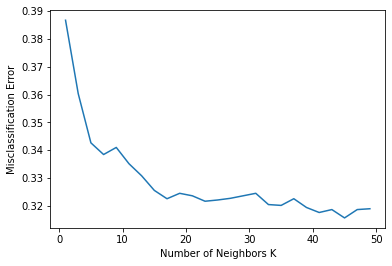

In [31]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, trainPCA, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [32]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(trainPCA, y_train)
pred = knn.predict(testPCA)
print("\nOptimal accuracy on the test set is", accuracy_score(y_test, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 45

Optimal accuracy on the test set is 0.6848256023013305 with k= 45


## Use of StandardScaler

In [106]:
from sklearn.preprocessing import StandardScaler

# Scaling features
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_val_standard = scaler.transform(X_val)
X_test_standard = scaler.transform(X_test)

In [107]:
import time

# Split Data to Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_standard, y_train, test_size=0.4)
clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train, y_train)
val_score = estimator.score(X_val, y_val)

preds = estimator.predict(X_test)
test_score = estimator.score(X_test, y_test)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 1.825829029083252 seconds
              precision    recall  f1-score   support

   home_loss       0.56      0.28      0.37      2520
    home_win       0.63      0.85      0.72      3609

    accuracy                           0.61      6129
   macro avg       0.59      0.56      0.55      6129
weighted avg       0.60      0.61      0.58      6129

val score: 0.6598360655737705
KNeighborsClassifier(leaf_size=1, n_neighbors=13)
{'leaf_size': 1, 'n_neighbors': 13}
best score: 0.6849315068493151
test score 0.6138032305433186


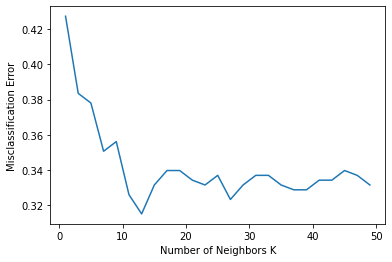

In [108]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [109]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print("\nOptimal accuracy on the test set is", accuracy_score(y_test, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 13

Optimal accuracy on the test set is 0.6138032305433186 with k= 13


## Use of MinMax Scaler

In [110]:
from sklearn.preprocessing import MinMaxScaler

# Scaling features
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_val_minmax = scaler.transform(X_val)
X_test_minmax = scaler.transform(X_test)


In [111]:
import time

# Split Data to Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_minmax, y_train, test_size=0.4)
clf = KNeighborsClassifier()
# η παράμετρος n_jobs = 1 χρησιμοποιεί όλους τους πυρήνες του υπολογιστή
params = {'n_neighbors': np.arange(1, 15),
          'leaf_size': list(range(1, 5, 1))}

estimator = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
start_time = time.time()
estimator.fit(X_train, y_train)
val_score = estimator.score(X_val, y_val)

preds = estimator.predict(X_test)
test_score = estimator.score(X_test, y_test)

target_names = ['home_loss', 'home_win']

print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, preds, target_names=target_names))
print("val score:", val_score)
print(estimator.best_estimator_)
print(estimator.best_params_)
print("best score:", estimator.best_score_)
print("test score", test_score)



Συνολικός χρόνος fit και predict: 1.5245349407196045 seconds
              precision    recall  f1-score   support

   home_loss       0.46      0.84      0.60      2520
    home_win       0.74      0.32      0.44      3609

    accuracy                           0.53      6129
   macro avg       0.60      0.58      0.52      6129
weighted avg       0.62      0.53      0.51      6129

val score: 0.6506849315068494
KNeighborsClassifier(leaf_size=1, n_neighbors=12)
{'leaf_size': 1, 'n_neighbors': 12}
best score: 0.6891120507399575
test score 0.5315712187958884


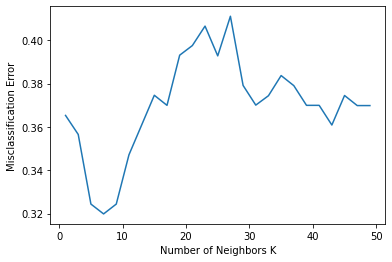

In [112]:
import matplotlib.pyplot as plt


# φτιάχνουμε μια λίστα από το 1 έως το 50
myList = list(range(1, 50))
# Κρατάμε μόνο τα περιττά k
neighbors = list(filter(lambda x: x % 2 != 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# το σφάλμα είναι το αντίστροφο της πιστότητας
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [113]:
# determining best k
optimal_k = neighbors[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print("\nOptimal accuracy on the test set is", accuracy_score(y_test, pred), "with k=", optimal_k)

The optimal number of neighbors (calculated in the training set) is 7

Optimal accuracy on the test set is 0.41034426496981563 with k= 7
